# LSTM_RNN

### Model
- model = LSTM
- batch_size = 32
- epochs = 100
- loss = mse

### Data
- time frame: 6 months | 6 months
- features: all of them (110)
- target: EDSS_6...EDSS_222
- imputation 
    - target: interpolation (trailing ends for extrapolation)
    - features: zero-imputation
- time steps: exhaustive (37)

In [15]:
from __future__ import print_function
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
import sklearn as sk
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

def select_columns(col_list, n_months):
    """
    Takes in a list of column names and number of visits starting at 0.
    Returns column list time-stepped and dovetailed.
    """ 
    return dovetail_names(*[time_step_names(i, n_months) for i in col_list])
        
def time_step_names(name, n_months):

    return [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6)]

def dovetail_names(*kwargs):
    """
    Dovetails column names across time slices cccording to preset order.
    """
    zipped = zip(*kwargs)
    l = []
   
    for i in zipped:
        
        for j in i:
            
            l.append(j)
            
    return l

def stack_times(data, name, n):
    """
    Takes in wide-format dataframe, column name and n of time steps.
    Returns long-foramt dataframe.
    """
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        
        l.append(data[col].copy())
    
    stacked = l[0]
    rest = l[1:]

    stacked.append(rest) # Stack Series and get dummy variables 
    
    return stacked

def stack_dummy(data, name, n):
    """
    Takes in dataframe and column name.
    Returns that same feature split into dummy columns
    across n time steps (adjacent).
    """
    all_names = select_columns(name, n-1)
    
    l = []
    
    for col in all_names:
        
        l.append(data[col].copy())
    
    f = l[0]
    rest = l[1:]
    
    pre_dummy = pd.get_dummies(f.append(rest)) # Stack Series and get dummy variables 
    after_dummy = time_dummy(pre_dummy, n)
    
    dummy_value_names = generate_col_names(after_dummy, name)
    time_stepped_dummy_names = time_step_dummy_value_names(dummy_value_names, n)
    
    for t in range(len(after_dummy)):
        
        after_dummy[t].columns = list(time_stepped_dummy_names[t])
        
    return pd.concat(after_dummy, axis = 1, sort = False), dummy_value_names


def time_dummy(dummy_df, n):
    """
    Separates long data frame into time steps 
    (i.e. 508 subjects (rows) per time step)
    """
    l = []
    
    for i in range(n):
        
        l.append(dummy_df.iloc[i*508:(i+1)*508,:].copy())
    
    return l

def generate_col_names(after_dummy, name):
    """
    Generates column names for result of pd.get_dummies on a feature
    i.e. if A has values x and y, it will generate A_x, A_y
    """
    return [(str(name[0]) + "_" + str(list(after_dummy[0].columns)[i])) 
            for i in range(len(list(after_dummy[0].columns)))]

def time_step_dummy_value_names(names, n_months):
    
    long_list = [(name + '_%d' % (j+1)) for j in range(-1,n_months*6, 6) for name in names]
    
    return np.array(long_list).reshape(-1, len(names))

def add_columns(add_to, name, names_per_t, n):
    """
    Adds new dummied features to dataframes (copies).
    
    Removes undummied version of features.
    
    Function wraps around stack_dummy() function.
    
    Argument "name" must be a list dtype. 
    """
    n = n + 1
    to_add, bare_names = stack_dummy(df, name, n)
    to_remove = select_columns(name, n-1)
    
    newdf = add_to.copy()
    column_names = list(to_add.columns)
    
    for i in range(len(column_names)):
        
        newdf[column_names[i]] = to_add.iloc[:,i]
        
    newdf.drop(to_remove,axis = 1, inplace = True)
    names_per_t_updated = column_names_per_time_step(names_per_t, bare_names, name[0])
    namesOrder= select_columns(names_per_t_updated, n-1)
    
    return newdf[namesOrder].copy(), names_per_t_updated

def column_names_per_time_step(original_list, add, remove):
    """
    Places EDSS column at the end of the time slice
    Removes previous
    """
    new_list = original_list.copy()

    new_list.remove(remove)
    new_list.extend(add)
    
    new_list.remove('EDSS')
    new_list.append('EDSS')
    
    return new_list

def manual_dummy(df, names, name_list, n):
    
    dfUpdated =df.copy()
    
    names = [[name] for name in names] # turn to list format 
    
    for name in names:
        
        dfUpdated, name_list = add_columns(dfUpdated, name , name_list, n)
   
    return dfUpdated 

# Import Data & Define Parameters

In [17]:
X = pd.read_csv("data/X_6_months|6_months_exhaustive.csv", index_col = 0)
y = pd.read_csv("data/y_6_months|6_months_exhaustive.csv", index_col = 0)

n_time_steps = len(y.columns)
n_inputs_pure = X.columns.tolist().index("EDSS_0")+1
pot = 1

print("The RNN window will slide", n_time_steps, "times")
print("The input length of the training data will be", pot, "time slices, separated by 6 month intervals")
print(n_inputs_pure, "featues comprise one time slice")

The RNN window will slide 37 times
The input length of the training data will be 1 time slices, separated by 6 month intervals
110 featues comprise one time slice


# Split into train and test

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

X_train_reshaped = X_train.values.reshape(-1, n_time_steps, n_inputs_pure) 
y_train_reshaped = y_train.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_train_reshaped.shape))
print("y reshaped is " + str(y_train_reshaped.shape))

X_test_reshaped = X_test.values.reshape(-1, n_time_steps, n_inputs_pure)
y_test_reshaped = y_test.values.reshape(-1, n_time_steps, 1)
print("X reshaped is " + str(X_test_reshaped.shape))
print("y reshaped is " + str(y_test_reshaped.shape))

y_train = y_train_reshaped.astype(float)
y_test = y_test_reshaped.astype(float)
X_train = X_train_reshaped.astype(float)
X_test = X_test_reshaped.astype(float)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

X reshaped is (355, 37, 110)
y reshaped is (355, 37, 1)
X reshaped is (153, 37, 110)
y reshaped is (153, 37, 1)
(355, 37, 110) (355, 37, 1) (153, 37, 110) (153, 37, 1)


# Set values for the neuron

In [19]:
n_inputs = n_inputs_pure * pot

n_units = 64

learning_rate = 0.01

n_steps = n_time_steps

print(pot, "time slice per time step comprising", n_inputs_pure, "features each")

1 time slice per time step comprising 110 features each


# Define Graph

In [ ]:
# same as reshaping X_train, X_test, y_train, y_test, etc... except that instead of -1, we use None
X_tf = tf.placeholder(tf.float32, [None, n_time_steps, n_inputs], name = "X") # [None, 8, 27]
y_tf = tf.placeholder(tf.float32, [None, n_time_steps, 1], name = "y") # changed from tf.float32 to tf.int32 

lstm_cell = tf.contrib.rnn.LSTMCell(num_units = n_units, use_peepholes = True)
output_seqs, (c_states, h_states) = tf.nn.dynamic_rnn(lstm_cell, X_tf, dtype = tf.float32)

predictions = tf.contrib.layers.fully_connected(output_seqs, 1, activation_fn=tf.nn.relu)

loss = tf.losses.mean_squared_error(labels = y_tf, predictions = predictions)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# Run Graph

In [14]:
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())

n_epochs = 100
batch_sz = 32
mse_train = []
mse_test = []
allpredictions = []
alloutputs = []
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iter in range(len(X_train) // batch_sz):

            X_batch, y_batch = X_train[iter*batch_sz: (iter+1)*batch_sz], y_train[iter*batch_sz: (iter+1)*batch_sz]
            X_batch = X_batch.reshape(-1, n_steps, n_inputs)
            y_batch = y_batch.reshape(-1,n_steps, 1) # added 1
            sess.run(training_op, feed_dict={X_tf: X_batch, y_tf: y_batch})
                
        
        mse_train.append(sess.run(loss, feed_dict={X_tf: X_batch, y_tf: y_batch}))
    
        X_test_batch = X_test.reshape(-1, n_steps, n_inputs)
        y_test_batch = y_test.reshape(-1,n_steps,1)   
        
        mse_test.append(sess.run(loss, feed_dict={X_tf : X_test_batch, y_tf : y_test_batch}))
        
        allpredictions.append(sess.run(predictions, feed_dict={X_tf: X_test_batch}))

# Plot Results

Best Test Score 0.31454462
Epoch: 25


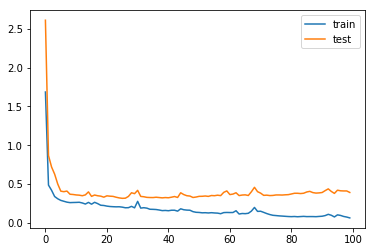

In [26]:
plt.plot(mse_train)
plt.plot(mse_test)
plt.legend(['train','test'])

print("Best Test Score",np.min(mse_test))
print("Epoch:",np.argmin(mse_test))